In [1]:
# notebooks/create_scenarios.ipynb

from scripts.create_data import create_data_scenario
from scripts.logger import log_scenario_folder, mark_log_as_finished
import random
from datetime import datetime
from scripts.logger import create_new_id
import os

# Initialize logging ID
logs_id = create_new_id("scenario")

# Define logging inputs
logging_inputs = {
    "num_scenarios": 10,
    "aircraft_range": (3, 3),
    "amount_aircraft_disrupted": 1,
    "average_flights_per_aircraft": 12,
    "std_dev_flights_per_aircraft": 1,
    "min_delta_start_unavailability": 120,
    "max_delta_start_unavailability": 150,
    "min_period_unavailability": 120,
    "max_period_unavailability": 1020,
    "probability_range": (0.0, 0.5),
    "probability_distribution": 'uniform',
    "clear_one_random_aircraft": False,
    "clear_random_flights": False,
    "first_flight_dep_time_range": (6, 8),
    "flight_length_range": (2, 5),
    "time_between_flights_range": (0, 1),
}

# Fixed inputs
template_folder = "../data/Template"
data_root_folder = "../data/Training/3ac-1-proactive-example/"
airports = [
    'AMS', 'CDG', 'FRA', 'LHR', 'MAD', 'MUC', 'ORY', 'TXL', 'VIE', 'ZRH', 
    'BCN', 'BRU', 'CPH', 'DUB', 'IST'
]
aircraft_types = [
    {'Model': 'A320', 'Family': 'Airbus', 'Config': '0/0/123', 'Dist': 5000, 'Cost/h': 1800.0, 
     'TurnRound': 30, 'Transit': 30, 'Orig': ['CFE'], 'Maint': ['NULL']}
    # Add more aircraft types if needed
]
config_dict = {
    'DelayCosts': [{'Cabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 100.0}],
    'CancellationCostsOutbound': [{'Cabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 500.0}],
    'CancellationCostsInbound': [{'Cabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 600.0}],
    'DowngradingCosts': [{'FromCabin': 'Business', 'ToCabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 200.0}],
    'PenaltyCosts': [200, 300, 400],
    'Weights': [1.0, 0.5, 0.2],
}

# Initialize outputs dictionary
logging_outputs = {}

# Function to generate scenarios
for i in range(1, logging_inputs["num_scenarios"] + 1):
    scenario_name = f'Scenario_{i:02d}'  # Dynamically generate scenario names
    recovery_start_date = datetime(2024, 9, random.randint(1, 30)).strftime('%d/%m/%y')
    recovery_start_time = f'{random.randint(5, 7)}:00'
    recovery_end_date = recovery_start_date
    recovery_end_time = f'{random.randint(20, 23)}:{random.choice(["00", "30"])}'

    # Call the function for each scenario
    data_folder, inputs, outputs = create_data_scenario(
        scenario_name=scenario_name,
        template_folder=template_folder,
        data_root_folder=data_root_folder,
        aircraft_types=aircraft_types,
        total_aircraft_range=logging_inputs["aircraft_range"],
        amount_aircraft_disrupted=logging_inputs["amount_aircraft_disrupted"],
        min_delta_start_unavailability=logging_inputs["min_delta_start_unavailability"],
        max_delta_start_unavailability=logging_inputs["max_delta_start_unavailability"],
        min_period_unavailability=logging_inputs["min_period_unavailability"],
        max_period_unavailability=logging_inputs["max_period_unavailability"],
        average_flights_per_aircraft=logging_inputs["average_flights_per_aircraft"],
        std_dev_flights_per_aircraft=logging_inputs["std_dev_flights_per_aircraft"],
        airports=airports,
        config_dict=config_dict,
        recovery_start_date=recovery_start_date,
        recovery_start_time=recovery_start_time,
        recovery_end_date=recovery_end_date,
        recovery_end_time=recovery_end_time,
        clear_one_random_aircraft=logging_inputs["clear_one_random_aircraft"],
        clear_random_flights=logging_inputs["clear_random_flights"],
        probability_range=logging_inputs["probability_range"],
        probability_distribution=logging_inputs["probability_distribution"],
        first_flight_dep_time_range=logging_inputs["first_flight_dep_time_range"],
        flight_length_range=logging_inputs["flight_length_range"],
        time_between_flights_range=logging_inputs["time_between_flights_range"],
    )

    # Add scenario outputs to logging_outputs
    logging_outputs[scenario_name] = outputs

# Define the full data_folder path (assuming all scenarios are in the same folder)
# If scenarios are in separate folders, adjust accordingly
# Here, since num_scenarios=1, it's straightforward
scenario_folder_path = os.path.join(data_root_folder, scenario_name)

# Log the scenarios
log_scenario_folder(
    logs_id=logs_id,
    scenario_folder_path=data_root_folder,
    inputs=logging_inputs,
    outputs=logging_outputs
)

# Mark the log as finished
mark_log_as_finished(logs_id)


*****flights_dict: {1: {'Orig': 'BCN', 'Dest': 'MUC', 'DepTime': '06:00', 'ArrTime': '09:33', 'PrevFlight': 0, 'Aircraft': 'A320#1'}, 2: {'Orig': 'BCN', 'Dest': 'IST', 'DepTime': '10:30', 'ArrTime': '15:28', 'PrevFlight': 0, 'Aircraft': 'A320#1'}, 3: {'Orig': 'AMS', 'Dest': 'MUC', 'DepTime': '16:20', 'ArrTime': '20:50', 'PrevFlight': 0, 'Aircraft': 'A320#1'}, 4: {'Orig': 'CDG', 'Dest': 'MAD', 'DepTime': '08:30', 'ArrTime': '13:11', 'PrevFlight': 0, 'Aircraft': 'A320#2'}, 5: {'Orig': 'MAD', 'Dest': 'CPH', 'DepTime': '13:35', 'ArrTime': '16:44', 'PrevFlight': 0, 'Aircraft': 'A320#2'}, 6: {'Orig': 'MAD', 'Dest': 'LHR', 'DepTime': '17:35', 'ArrTime': '21:15', 'PrevFlight': 0, 'Aircraft': 'A320#2'}, 7: {'Orig': 'CPH', 'Dest': 'BRU', 'DepTime': '06:30', 'ArrTime': '08:34', 'PrevFlight': 0, 'Aircraft': 'A320#3'}, 8: {'Orig': 'CDG', 'Dest': 'AMS', 'DepTime': '09:25', 'ArrTime': '13:48', 'PrevFlight': 0, 'Aircraft': 'A320#3'}, 9: {'Orig': 'VIE', 'Dest': 'CDG', 'DepTime': '13:51', 'ArrTime': '16

### Visualize them

Processing scenario: Scenario_01
{'A320#1': {'StartDate': '17/09/24', 'StartTime': '08:12', 'EndDate': '17/09/24', 'EndTime': '17:58', 'Probability': 0.47}, 'A320#2': {'StartDate': '17/09/24', 'StartTime': '08:14', 'EndDate': '17/09/24', 'EndTime': '11:57', 'Probability': 1.0}, 'A320#3': {'StartDate': '17/09/24', 'StartTime': '08:01', 'EndDate': '17/09/24', 'EndTime': '19:30', 'Probability': 0.39}}
*****config_dict['RecoveryPeriod']['StartDate']: 17/09/24
*****this_day_flights: [{'Orig': 'BCN', 'Dest': 'MUC', 'DepTime': '06:00', 'ArrTime': '09:33', 'PrevFlight': 0}, {'Orig': 'BCN', 'Dest': 'IST', 'DepTime': '10:30', 'ArrTime': '15:28', 'PrevFlight': 0}, {'Orig': 'AMS', 'Dest': 'MUC', 'DepTime': '16:20', 'ArrTime': '20:50', 'PrevFlight': 0}, {'Orig': 'CDG', 'Dest': 'MAD', 'DepTime': '08:30', 'ArrTime': '13:11', 'PrevFlight': 0}, {'Orig': 'MAD', 'Dest': 'CPH', 'DepTime': '13:35', 'ArrTime': '16:44', 'PrevFlight': 0}, {'Orig': 'MAD', 'Dest': 'LHR', 'DepTime': '17:35', 'ArrTime': '21:15', 

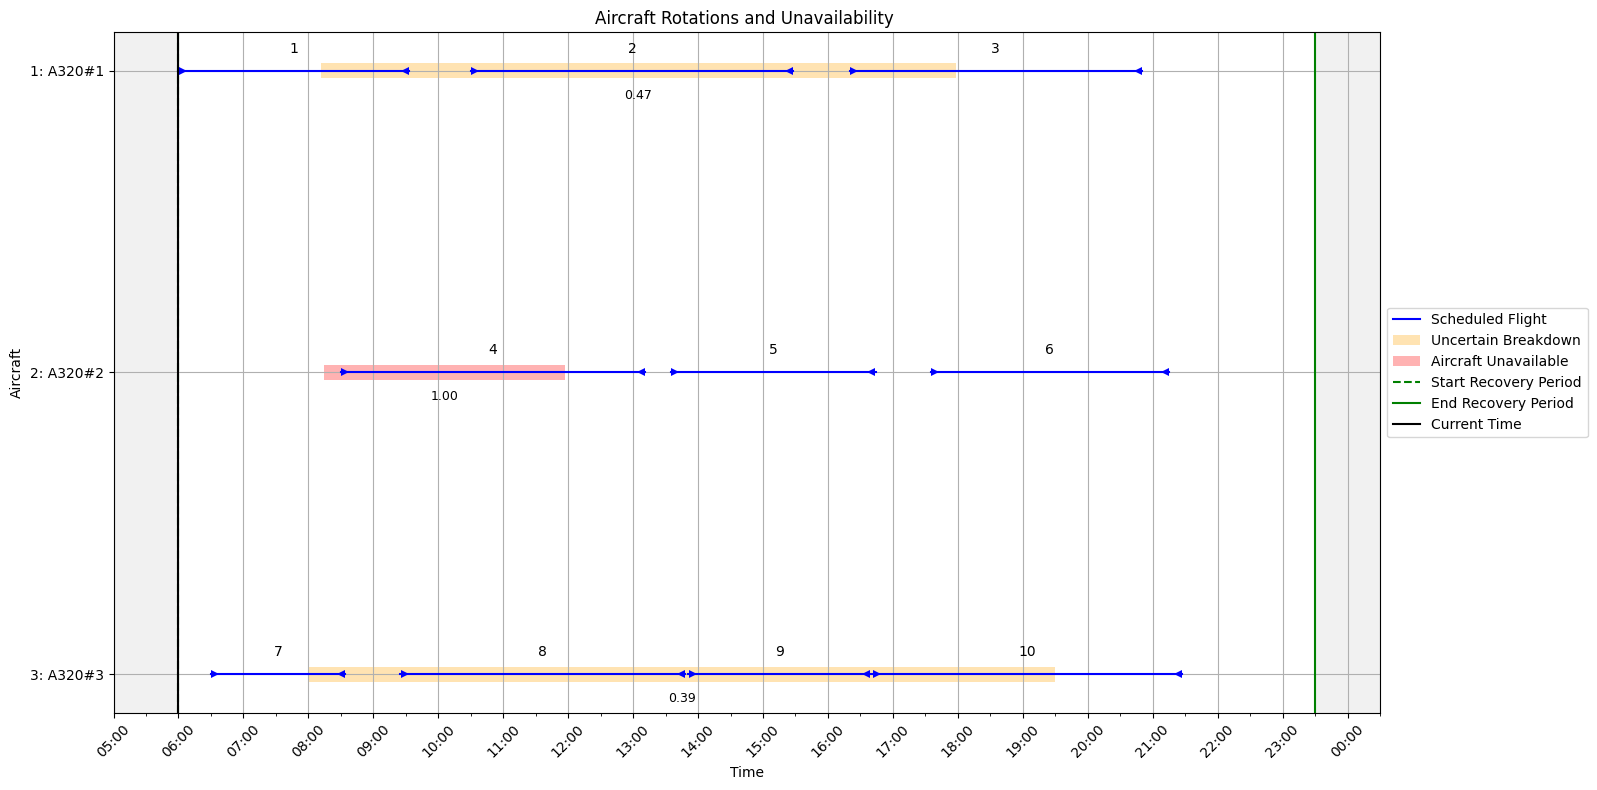

Processing scenario: Scenario_02
{'A320#1': {'StartDate': '13/09/24', 'StartTime': '09:01', 'EndDate': '13/09/24', 'EndTime': '21:25', 'Probability': 0.5}, 'A320#2': {'StartDate': '13/09/24', 'StartTime': '09:04', 'EndDate': '13/09/24', 'EndTime': '12:08', 'Probability': 1.0}, 'A320#3': {'StartDate': '13/09/24', 'StartTime': '09:06', 'EndDate': '13/09/24', 'EndTime': '22:36', 'Probability': 0.34}}
*****config_dict['RecoveryPeriod']['StartDate']: 13/09/24
*****this_day_flights: [{'Orig': 'IST', 'Dest': 'LHR', 'DepTime': '08:30', 'ArrTime': '12:33', 'PrevFlight': 0}, {'Orig': 'DUB', 'Dest': 'BRU', 'DepTime': '13:32', 'ArrTime': '17:05', 'PrevFlight': 0}, {'Orig': 'BRU', 'Dest': 'MAD', 'DepTime': '17:22', 'ArrTime': '19:24', 'PrevFlight': 0}, {'Orig': 'LHR', 'Dest': 'VIE', 'DepTime': '07:00', 'ArrTime': '10:38', 'PrevFlight': 0}, {'Orig': 'CDG', 'Dest': 'ZRH', 'DepTime': '11:04', 'ArrTime': '13:40', 'PrevFlight': 0}, {'Orig': 'LHR', 'Dest': 'BCN', 'DepTime': '13:59', 'ArrTime': '16:45', '

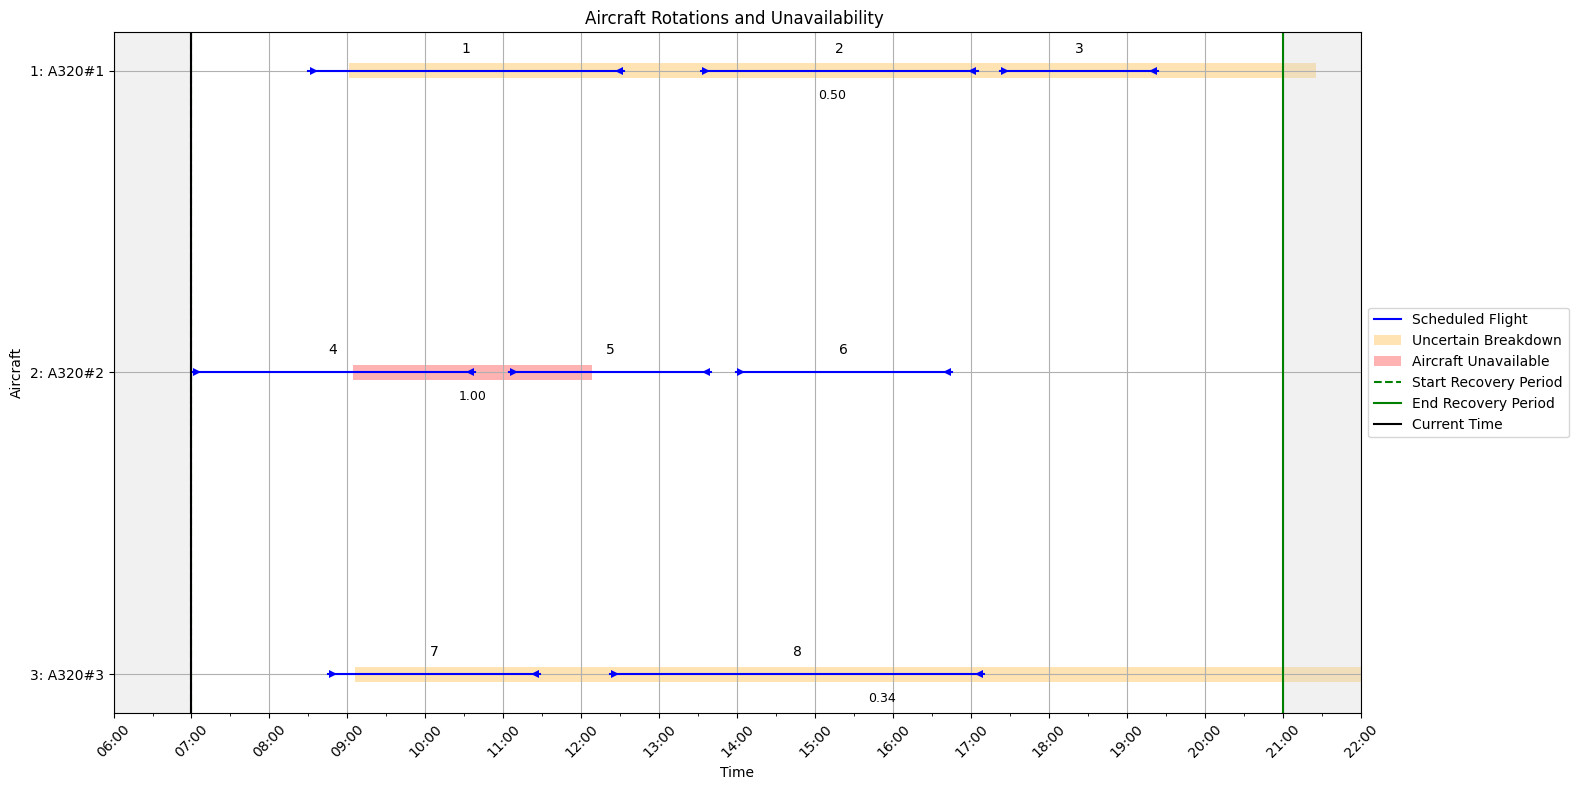

Processing scenario: Scenario_03
{'A320#1': {'StartDate': '06/09/24', 'StartTime': '09:04', 'EndDate': '06/09/24', 'EndTime': '16:00', 'Probability': 0.22}, 'A320#2': {'StartDate': '06/09/24', 'StartTime': '09:30', 'EndDate': '06/09/24', 'EndTime': '23:15', 'Probability': 0.46}, 'A320#3': {'StartDate': '06/09/24', 'StartTime': '09:08', 'EndDate': '06/09/24', 'EndTime': '12:27', 'Probability': 1.0}}
*****config_dict['RecoveryPeriod']['StartDate']: 06/09/24
*****this_day_flights: [{'Orig': 'MAD', 'Dest': 'BCN', 'DepTime': '08:00', 'ArrTime': '12:43', 'PrevFlight': 0}, {'Orig': 'CPH', 'Dest': 'ORY', 'DepTime': '13:29', 'ArrTime': '15:37', 'PrevFlight': 0}, {'Orig': 'LHR', 'Dest': 'FRA', 'DepTime': '16:12', 'ArrTime': '19:26', 'PrevFlight': 0}, {'Orig': 'AMS', 'Dest': 'BRU', 'DepTime': '07:30', 'ArrTime': '12:27', 'PrevFlight': 0}, {'Orig': 'MUC', 'Dest': 'VIE', 'DepTime': '13:12', 'ArrTime': '16:59', 'PrevFlight': 0}, {'Orig': 'IST', 'Dest': 'ZRH', 'DepTime': '17:43', 'ArrTime': '20:16', 

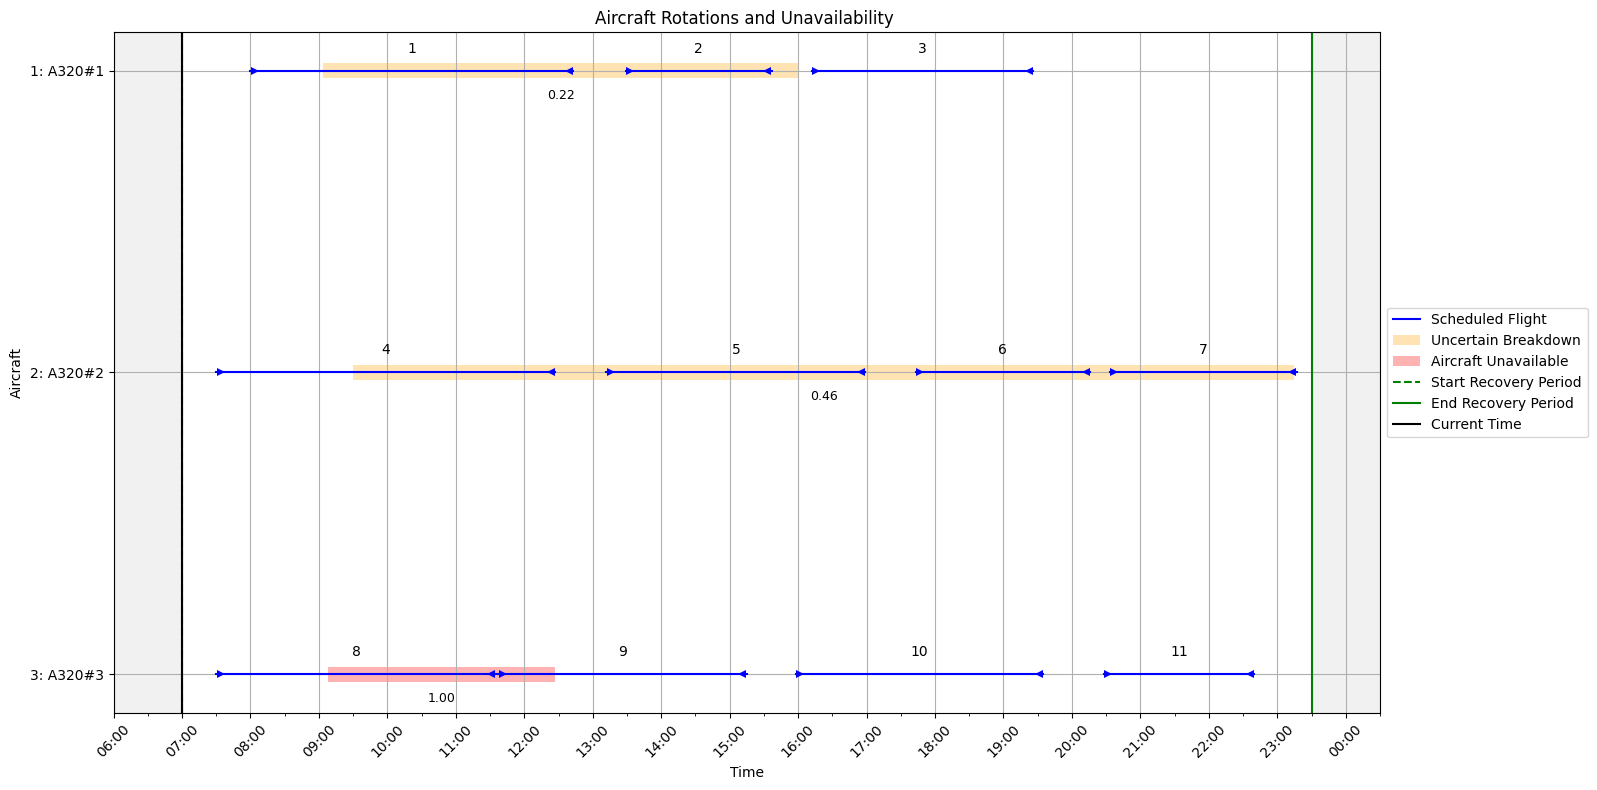

Processing scenario: Scenario_04
{'A320#1': {'StartDate': '18/09/24', 'StartTime': '09:06', 'EndDate': '19/09/24', 'EndTime': '00:07', 'Probability': 0.19}, 'A320#2': {'StartDate': '18/09/24', 'StartTime': '09:25', 'EndDate': '19/09/24', 'EndTime': '02:01', 'Probability': 0.31}, 'A320#3': {'StartDate': '18/09/24', 'StartTime': '09:04', 'EndDate': '18/09/24', 'EndTime': '15:23', 'Probability': 1.0}}
*****config_dict['RecoveryPeriod']['StartDate']: 18/09/24
*****this_day_flights: [{'Orig': 'MUC', 'Dest': 'LHR', 'DepTime': '07:30', 'ArrTime': '11:38', 'PrevFlight': 0}, {'Orig': 'ZRH', 'Dest': 'FRA', 'DepTime': '11:42', 'ArrTime': '16:18', 'PrevFlight': 0}, {'Orig': 'BRU', 'Dest': 'VIE', 'DepTime': '17:15', 'ArrTime': '19:38', 'PrevFlight': 0}, {'Orig': 'ORY', 'Dest': 'CPH', 'DepTime': '07:45', 'ArrTime': '11:03', 'PrevFlight': 0}, {'Orig': 'ORY', 'Dest': 'BRU', 'DepTime': '11:08', 'ArrTime': '14:51', 'PrevFlight': 0}, {'Orig': 'CDG', 'Dest': 'TXL', 'DepTime': '15:20', 'ArrTime': '20:18', 

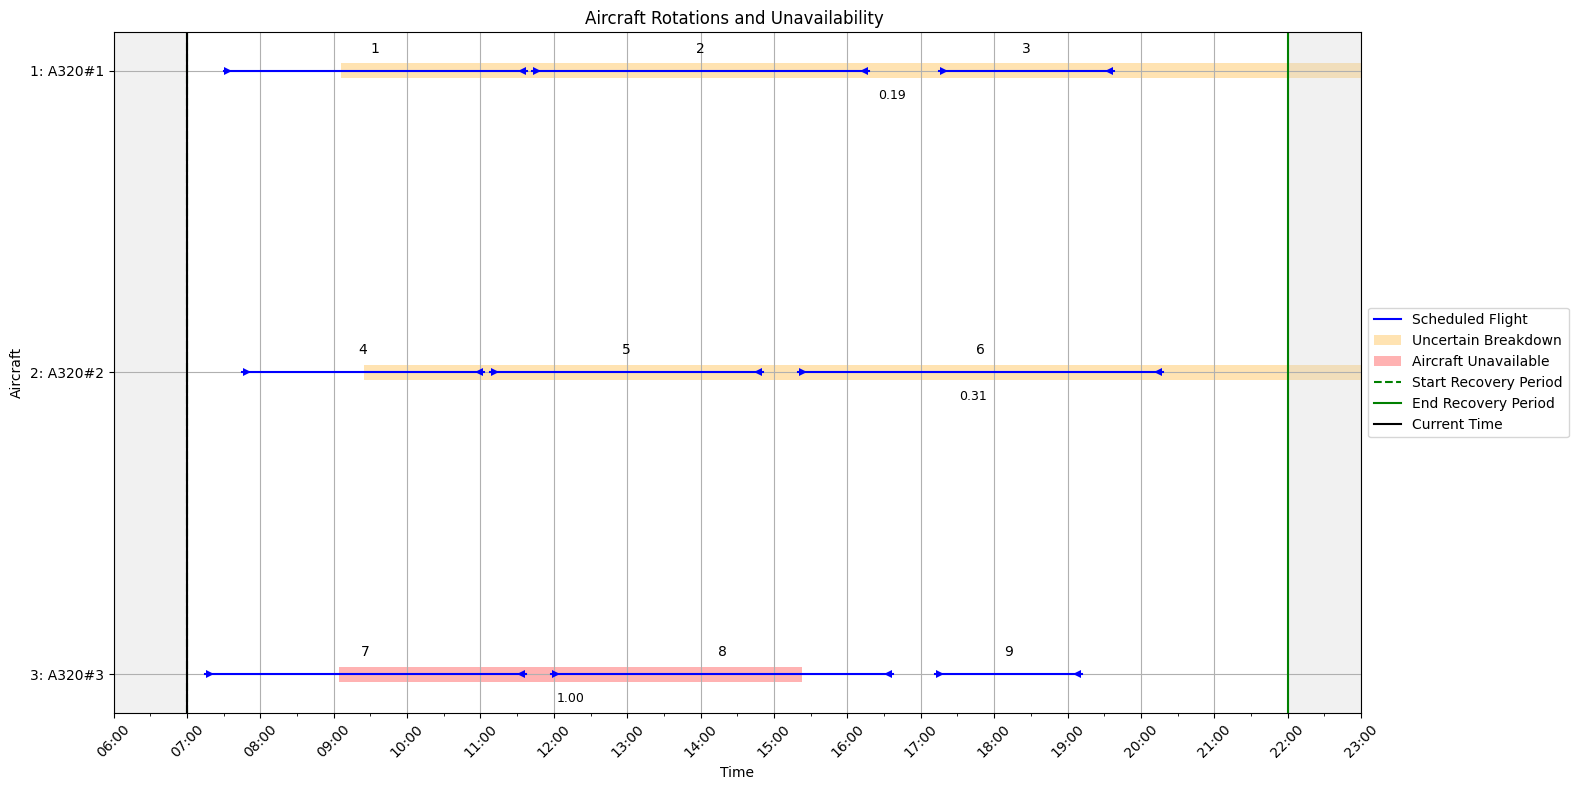

Processing scenario: Scenario_05
{'A320#1': {'StartDate': '28/09/24', 'StartTime': '08:27', 'EndDate': '29/09/24', 'EndTime': '00:36', 'Probability': 0.16}, 'A320#2': {'StartDate': '28/09/24', 'StartTime': '08:05', 'EndDate': '28/09/24', 'EndTime': '23:27', 'Probability': 1.0}, 'A320#3': {'StartDate': '28/09/24', 'StartTime': '08:06', 'EndDate': '28/09/24', 'EndTime': '15:12', 'Probability': 0.28}}
*****config_dict['RecoveryPeriod']['StartDate']: 28/09/24
*****this_day_flights: [{'Orig': 'MAD', 'Dest': 'CDG', 'DepTime': '08:15', 'ArrTime': '11:53', 'PrevFlight': 0}, {'Orig': 'LHR', 'Dest': 'ORY', 'DepTime': '12:25', 'ArrTime': '14:55', 'PrevFlight': 0}, {'Orig': 'TXL', 'Dest': 'ORY', 'DepTime': '15:05', 'ArrTime': '18:43', 'PrevFlight': 0}, {'Orig': 'BCN', 'Dest': 'DUB', 'DepTime': '07:45', 'ArrTime': '10:06', 'PrevFlight': 0}, {'Orig': 'ZRH', 'Dest': 'BRU', 'DepTime': '11:01', 'ArrTime': '14:22', 'PrevFlight': 0}, {'Orig': 'TXL', 'Dest': 'CDG', 'DepTime': '15:05', 'ArrTime': '19:26', 

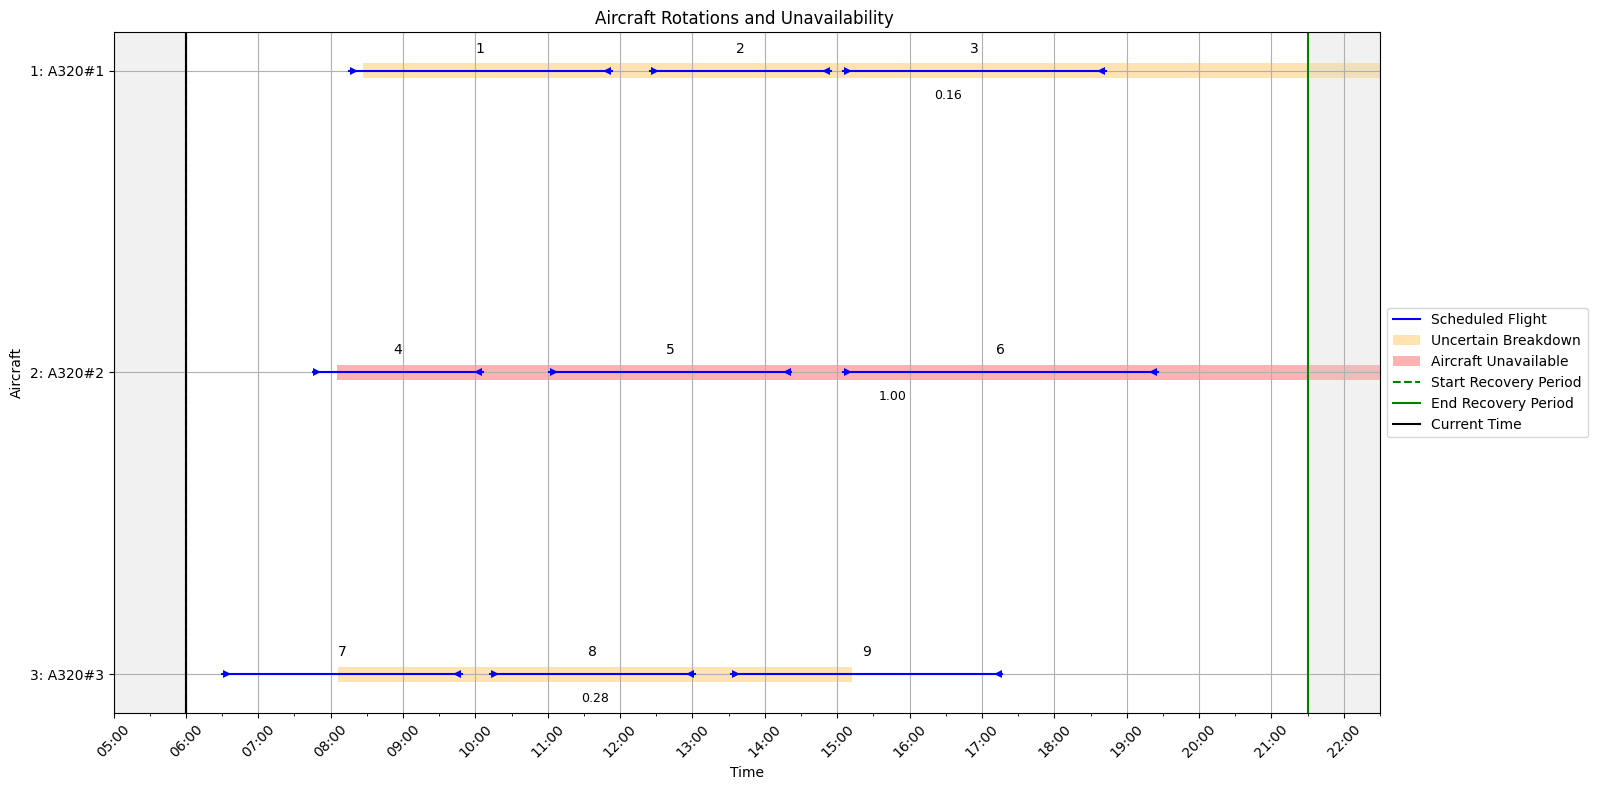

Processing scenario: Scenario_06
{'A320#1': {'StartDate': '17/09/24', 'StartTime': '08:22', 'EndDate': '17/09/24', 'EndTime': '11:29', 'Probability': 0.07}, 'A320#2': {'StartDate': '17/09/24', 'StartTime': '08:26', 'EndDate': '17/09/24', 'EndTime': '15:12', 'Probability': 1.0}, 'A320#3': {'StartDate': '17/09/24', 'StartTime': '08:11', 'EndDate': '17/09/24', 'EndTime': '21:19', 'Probability': 0.19}}
*****config_dict['RecoveryPeriod']['StartDate']: 17/09/24
*****this_day_flights: [{'Orig': 'ZRH', 'Dest': 'BRU', 'DepTime': '08:45', 'ArrTime': '11:44', 'PrevFlight': 0}, {'Orig': 'LHR', 'Dest': 'AMS', 'DepTime': '11:59', 'ArrTime': '14:48', 'PrevFlight': 0}, {'Orig': 'CPH', 'Dest': 'AMS', 'DepTime': '14:58', 'ArrTime': '18:50', 'PrevFlight': 0}, {'Orig': 'LHR', 'Dest': 'IST', 'DepTime': '08:45', 'ArrTime': '13:01', 'PrevFlight': 0}, {'Orig': 'DUB', 'Dest': 'BRU', 'DepTime': '13:58', 'ArrTime': '18:27', 'PrevFlight': 0}, {'Orig': 'CDG', 'Dest': 'DUB', 'DepTime': '07:30', 'ArrTime': '12:04', 

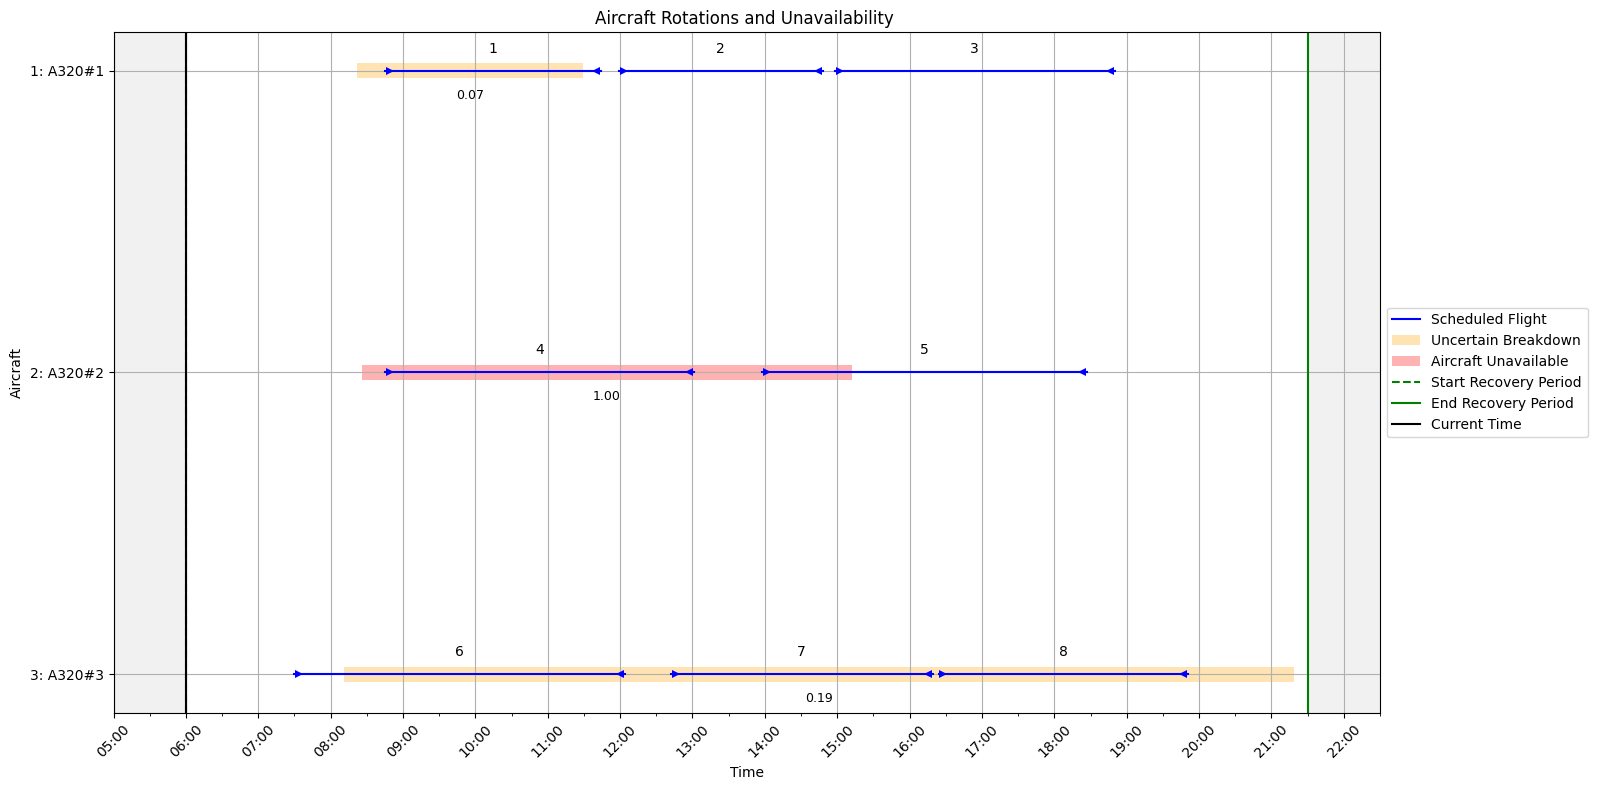

Processing scenario: Scenario_07
{'A320#1': {'StartDate': '12/09/24', 'StartTime': '08:17', 'EndDate': '12/09/24', 'EndTime': '23:11', 'Probability': 0.24}, 'A320#2': {'StartDate': '12/09/24', 'StartTime': '08:07', 'EndDate': '12/09/24', 'EndTime': '11:55', 'Probability': 1.0}, 'A320#3': {'StartDate': '12/09/24', 'StartTime': '08:13', 'EndDate': '12/09/24', 'EndTime': '17:17', 'Probability': 0.27}}
*****config_dict['RecoveryPeriod']['StartDate']: 12/09/24
*****this_day_flights: [{'Orig': 'ZRH', 'Dest': 'IST', 'DepTime': '07:45', 'ArrTime': '12:08', 'PrevFlight': 0}, {'Orig': 'BCN', 'Dest': 'MAD', 'DepTime': '12:47', 'ArrTime': '14:50', 'PrevFlight': 0}, {'Orig': 'BCN', 'Dest': 'MUC', 'DepTime': '15:15', 'ArrTime': '19:12', 'PrevFlight': 0}, {'Orig': 'LHR', 'Dest': 'VIE', 'DepTime': '08:45', 'ArrTime': '13:08', 'PrevFlight': 0}, {'Orig': 'TXL', 'Dest': 'ORY', 'DepTime': '14:01', 'ArrTime': '18:11', 'PrevFlight': 0}, {'Orig': 'CDG', 'Dest': 'ZRH', 'DepTime': '07:45', 'ArrTime': '10:08', 

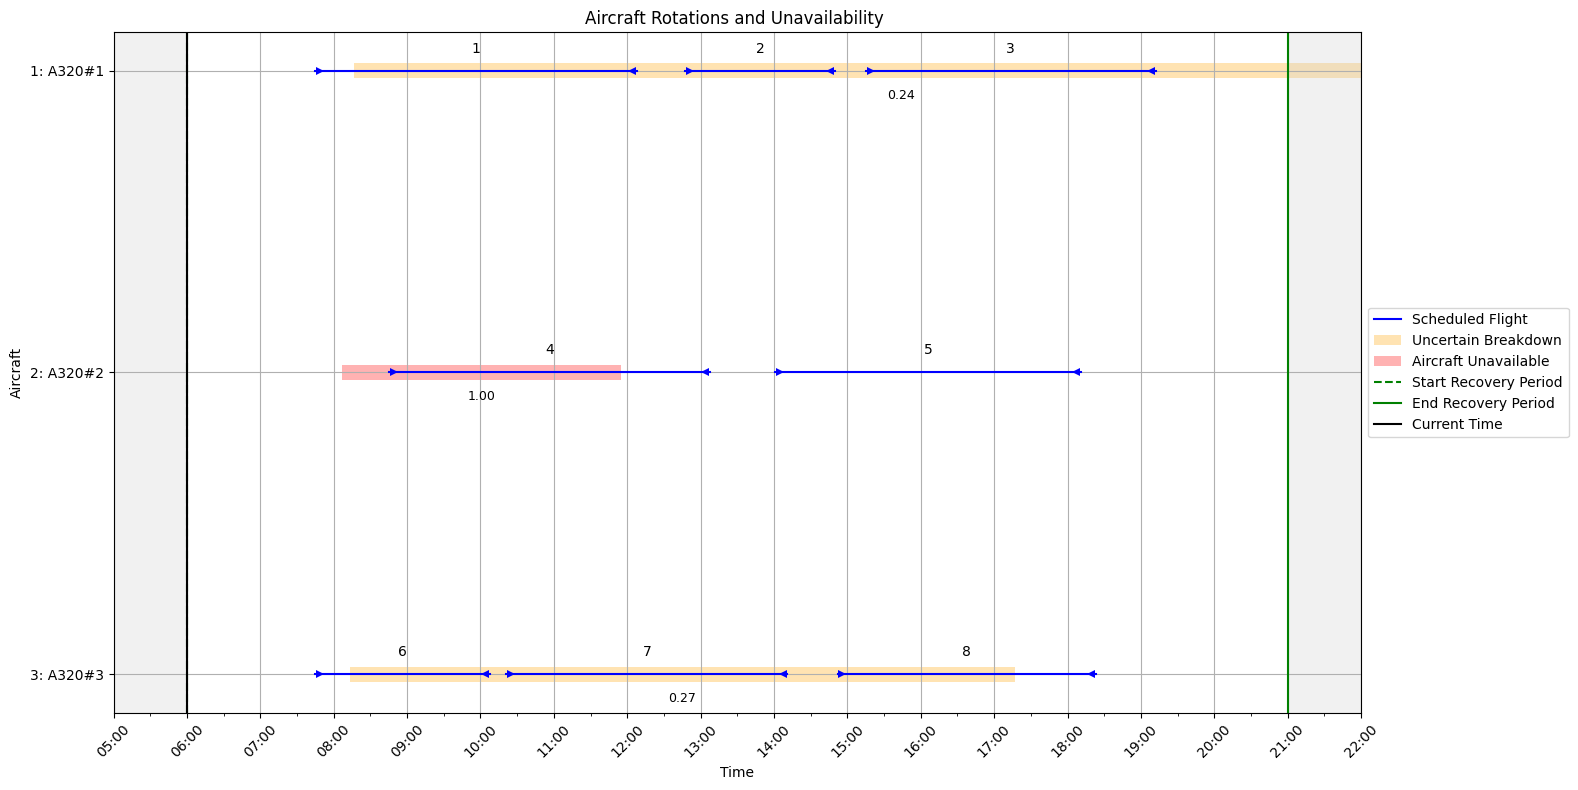

Processing scenario: Scenario_08
{'A320#1': {'StartDate': '13/09/24', 'StartTime': '09:00', 'EndDate': '13/09/24', 'EndTime': '19:59', 'Probability': 0.08}, 'A320#2': {'StartDate': '13/09/24', 'StartTime': '09:24', 'EndDate': '14/09/24', 'EndTime': '00:37', 'Probability': 0.16}, 'A320#3': {'StartDate': '13/09/24', 'StartTime': '09:21', 'EndDate': '13/09/24', 'EndTime': '12:35', 'Probability': 1.0}}
*****config_dict['RecoveryPeriod']['StartDate']: 13/09/24
*****this_day_flights: [{'Orig': 'LHR', 'Dest': 'CPH', 'DepTime': '07:45', 'ArrTime': '11:22', 'PrevFlight': 0}, {'Orig': 'VIE', 'Dest': 'BCN', 'DepTime': '12:05', 'ArrTime': '16:00', 'PrevFlight': 0}, {'Orig': 'DUB', 'Dest': 'CPH', 'DepTime': '16:14', 'ArrTime': '19:29', 'PrevFlight': 0}, {'Orig': 'CPH', 'Dest': 'ORY', 'DepTime': '08:00', 'ArrTime': '10:56', 'PrevFlight': 0}, {'Orig': 'DUB', 'Dest': 'ORY', 'DepTime': '11:06', 'ArrTime': '15:55', 'PrevFlight': 0}, {'Orig': 'AMS', 'Dest': 'MAD', 'DepTime': '16:21', 'ArrTime': '19:19', 

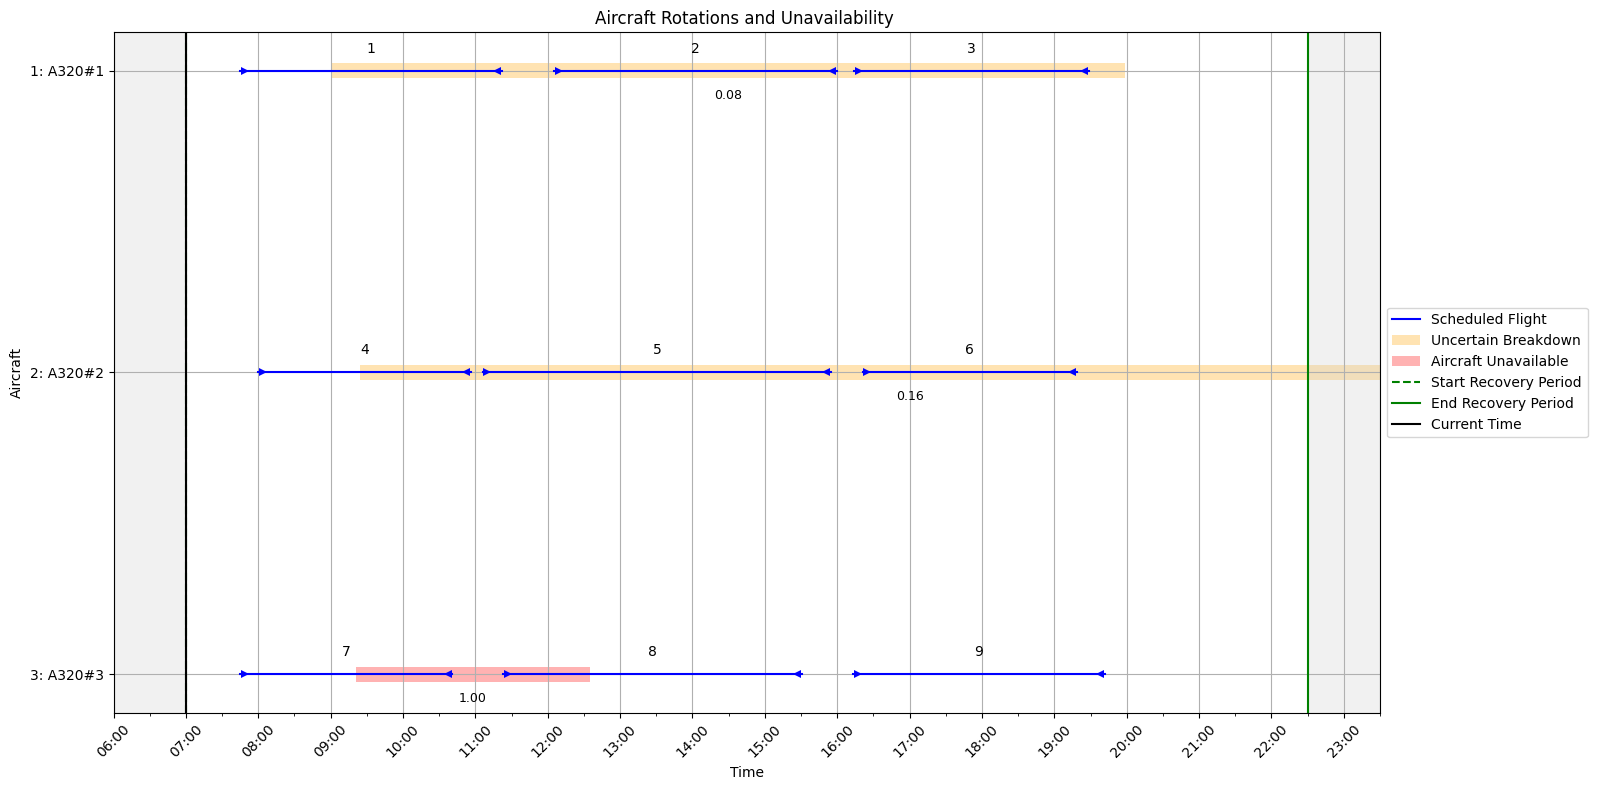

Processing scenario: Scenario_09
{'A320#1': {'StartDate': '12/09/24', 'StartTime': '07:22', 'EndDate': '12/09/24', 'EndTime': '21:43', 'Probability': 0.2}, 'A320#2': {'StartDate': '12/09/24', 'StartTime': '07:25', 'EndDate': '12/09/24', 'EndTime': '13:24', 'Probability': 1.0}, 'A320#3': {'StartDate': '12/09/24', 'StartTime': '07:22', 'EndDate': '12/09/24', 'EndTime': '20:15', 'Probability': 0.27}}
*****config_dict['RecoveryPeriod']['StartDate']: 12/09/24
*****this_day_flights: [{'Orig': 'ORY', 'Dest': 'ZRH', 'DepTime': '08:00', 'ArrTime': '12:16', 'PrevFlight': 0}, {'Orig': 'BCN', 'Dest': 'ZRH', 'DepTime': '12:32', 'ArrTime': '16:36', 'PrevFlight': 0}, {'Orig': 'BCN', 'Dest': 'FRA', 'DepTime': '06:00', 'ArrTime': '09:57', 'PrevFlight': 0}, {'Orig': 'CDG', 'Dest': 'MUC', 'DepTime': '10:01', 'ArrTime': '14:53', 'PrevFlight': 0}, {'Orig': 'BRU', 'Dest': 'VIE', 'DepTime': '15:51', 'ArrTime': '17:56', 'PrevFlight': 0}, {'Orig': 'ORY', 'Dest': 'CDG', 'DepTime': '07:15', 'ArrTime': '10:13', '

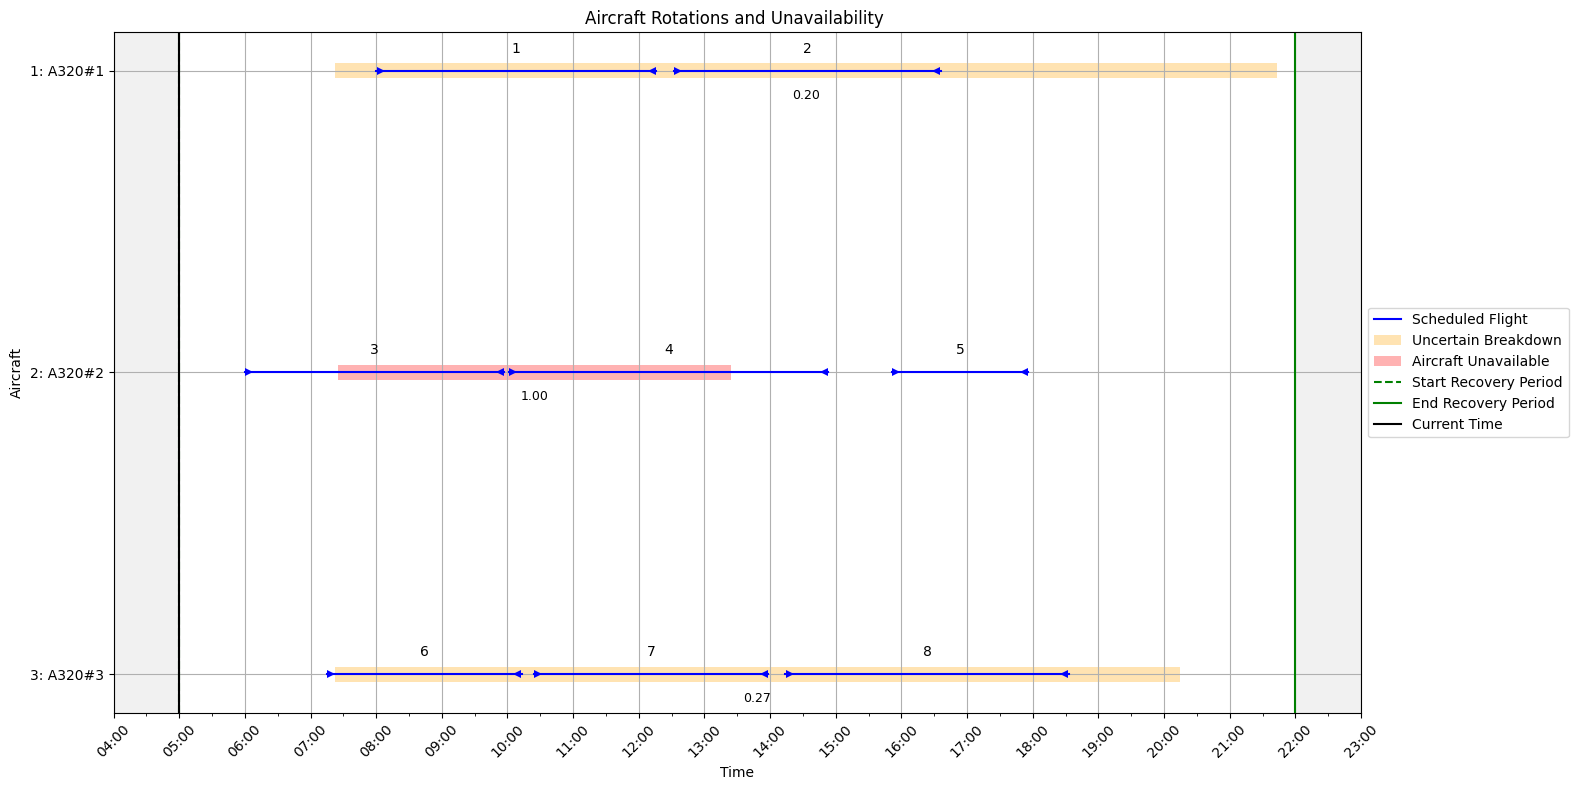

Processing scenario: Scenario_10
{'A320#1': {'StartDate': '04/09/24', 'StartTime': '08:29', 'EndDate': '04/09/24', 'EndTime': '17:54', 'Probability': 0.15}, 'A320#2': {'StartDate': '04/09/24', 'StartTime': '08:15', 'EndDate': '04/09/24', 'EndTime': '22:19', 'Probability': 0.25}, 'A320#3': {'StartDate': '04/09/24', 'StartTime': '08:04', 'EndDate': '04/09/24', 'EndTime': '20:28', 'Probability': 1.0}}
*****config_dict['RecoveryPeriod']['StartDate']: 04/09/24
*****this_day_flights: [{'Orig': 'MAD', 'Dest': 'BCN', 'DepTime': '07:45', 'ArrTime': '11:38', 'PrevFlight': 0}, {'Orig': 'MUC', 'Dest': 'CDG', 'DepTime': '11:44', 'ArrTime': '15:38', 'PrevFlight': 0}, {'Orig': 'CDG', 'Dest': 'MAD', 'DepTime': '06:00', 'ArrTime': '08:17', 'PrevFlight': 0}, {'Orig': 'LHR', 'Dest': 'BCN', 'DepTime': '08:25', 'ArrTime': '11:20', 'PrevFlight': 0}, {'Orig': 'ORY', 'Dest': 'VIE', 'DepTime': '12:14', 'ArrTime': '16:27', 'PrevFlight': 0}, {'Orig': 'CDG', 'Dest': 'BCN', 'DepTime': '07:30', 'ArrTime': '10:17', 

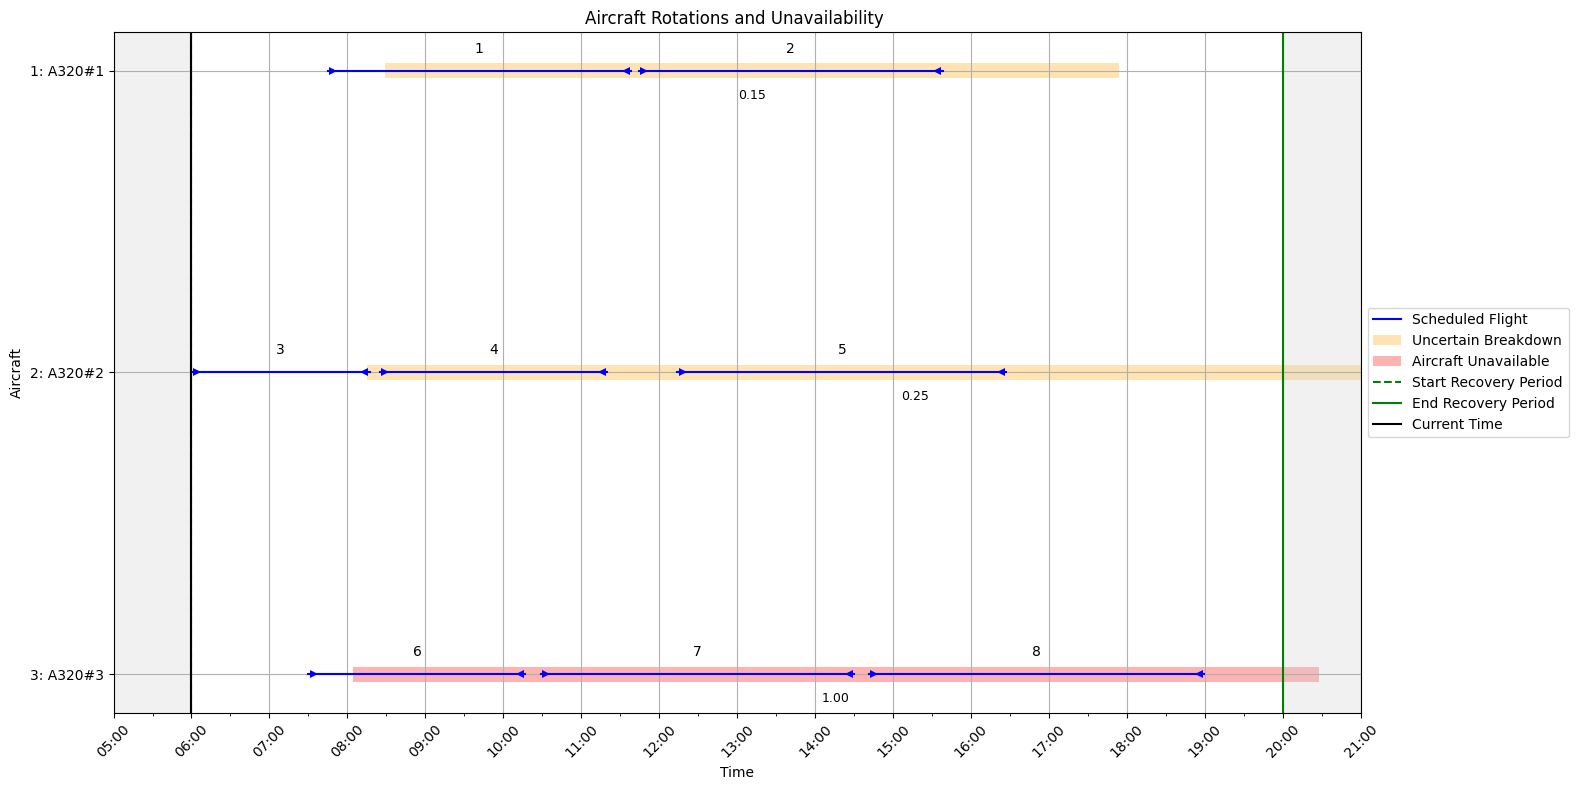

All scenarios processed successfully.


In [2]:
from scripts.visualizations import StatePlotter
from scripts.utils import load_scenario_data
import os
from src.environment import AircraftDisruptionEnv
from datetime import datetime
from scripts.utils import print_state_nicely_proactive

env_type = 'proactive'


# Verify that the root folder exists
if not os.path.exists(data_root_folder):
    raise FileNotFoundError(f"The data root folder does not exist: {data_root_folder}")

# Get the list of scenarios, sorted by name in ascending order
scenarios = sorted(
    [scenario for scenario in os.listdir(data_root_folder) if os.path.isdir(os.path.join(data_root_folder, scenario))]
)

# Process each scenario
for scenario_name in scenarios:
    scenario_path = os.path.join(data_root_folder, scenario_name)
    
    print(f"Processing scenario: {scenario_name}")

    # Verify that the scenario exists
    if not os.path.exists(scenario_path):
        print(f"Scenario {scenario_name} does not exist. Skipping...")
        continue

    # Load scenario data
    data_dict = load_scenario_data(scenario_path)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Print configuration details for verification
    # print(config_dict)

    # print alt_aircraft_dict
    print(alt_aircraft_dict)

    # Initialize the environment
    env = AircraftDisruptionEnv(
        aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict, env_type=env_type
    )
    # Print state with print_state_nicely_proactive
    print_state_nicely_proactive(env.state)
    
    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter(
        aircraft_dict=env.aircraft_dict,
        flights_dict=env.flights_dict,
        rotations_dict=env.rotations_dict,
        alt_aircraft_dict=env.alt_aircraft_dict,
        start_datetime=env.start_datetime,
        end_datetime=env.end_datetime,
        uncertain_breakdowns=env.uncertain_breakdowns,
    )



    # Define the recovery period based on provided configuration
    start_date = config_dict['RecoveryPeriod']['StartDate']
    start_time = config_dict['RecoveryPeriod']['StartTime']
    end_date = config_dict['RecoveryPeriod']['EndDate']
    end_time = config_dict['RecoveryPeriod']['EndTime']
    start_datetime = datetime.strptime(f"{start_date} {start_time}", '%d/%m/%y %H:%M')

    # Plot the state for the current scenario
    print(f"Plotting state for scenario: {scenario_name}")
    state_plotter.plot_state(flights_dict, [], [], set(), env.current_datetime)

print("All scenarios processed successfully.")
